# MLOps Pipeline with MLflow and scikit-learn
This notebook implements a complete MLOps-ready training pipeline using:
- The California Housing dataset
- Two models: Linear Regression and Random Forest
- MLflow tracking
- Feature-target visualizations
- Simple Data Cleansing - removed rows where values are missing

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import mlflow
import mlflow.sklearn

os.makedirs("model", exist_ok=True)

## Step 1: Load and Clean Data

In [11]:
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()

print("before dropping rows with missing values: ", len(df))

# Remove rows with missing values. 
df = df.dropna()

print("after dropping rows with missing values: ", len(df))
df.head()


before dropping rows with missing values:  20640
after dropping rows with missing values:  20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Step 2: Visualize Key Features vs Target

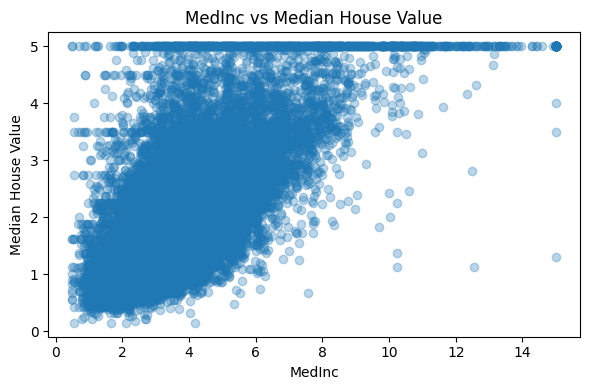

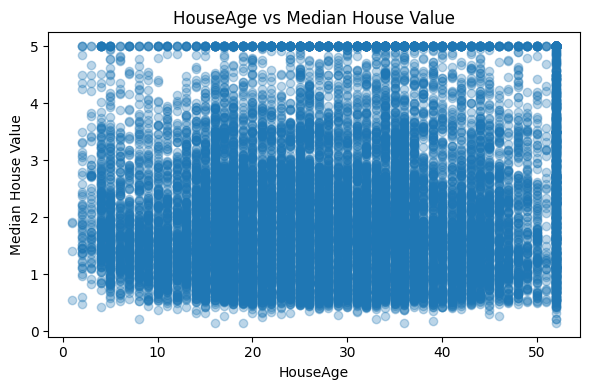

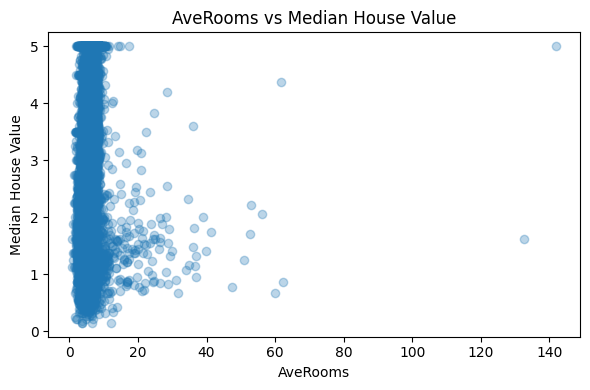

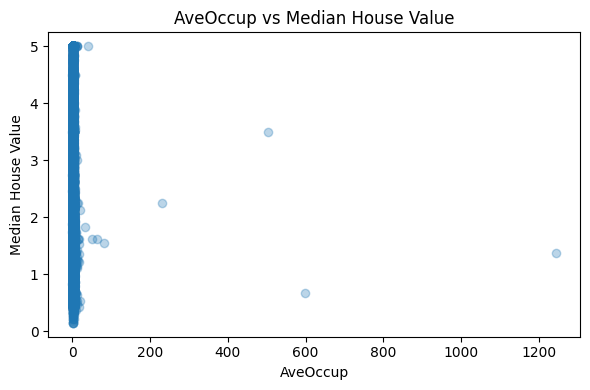

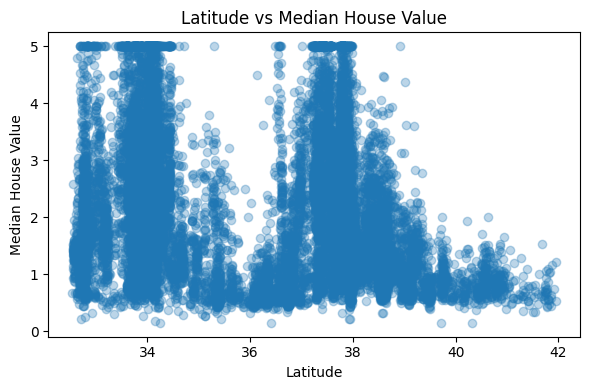

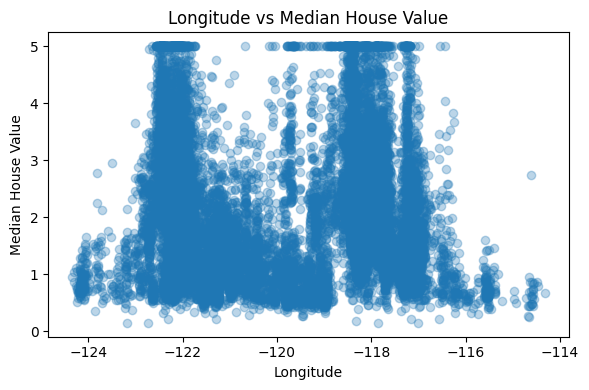

In [3]:
features_to_plot = ["MedInc", "HouseAge", "AveRooms", "AveOccup", "Latitude", "Longitude"]

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[feature], df["MedHouseVal"], alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel("Median House Value")
    plt.title(f"{feature} vs Median House Value")
    plt.tight_layout()
    plt.savefig(f"model/{feature}_vs_target.png")
    plt.show()

## Step 3: Prepare Training Data

In [4]:
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numerical_features = X.columns.tolist()

# normalize numerical features
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("scaler", StandardScaler())
    ]), numerical_features)
])

## Step 4: Train and Evaluate Models with MLflow

2025/07/27 22:57:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response body: '<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>
'


✅ LinearRegression RMSE: 0.5559


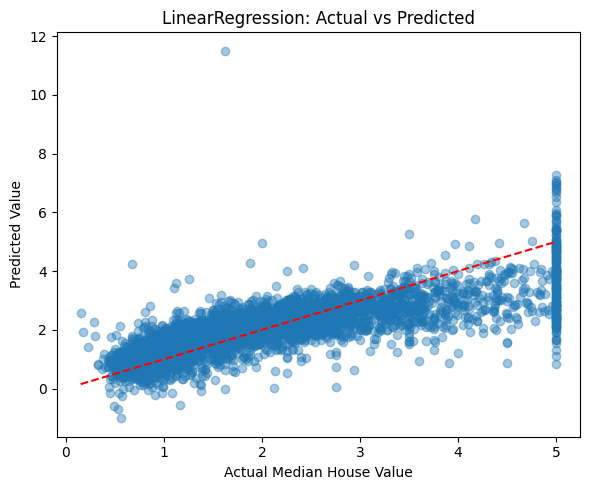

🏃 View run LinearRegression at: http://localhost:5000/#/experiments/291998293262015865/runs/8512755ea982409980fba4f3b5dd554a
🧪 View experiment at: http://localhost:5000/#/experiments/291998293262015865


2025/07/27 22:58:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response body: '<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>
'


✅ RandomForest RMSE: 0.2552


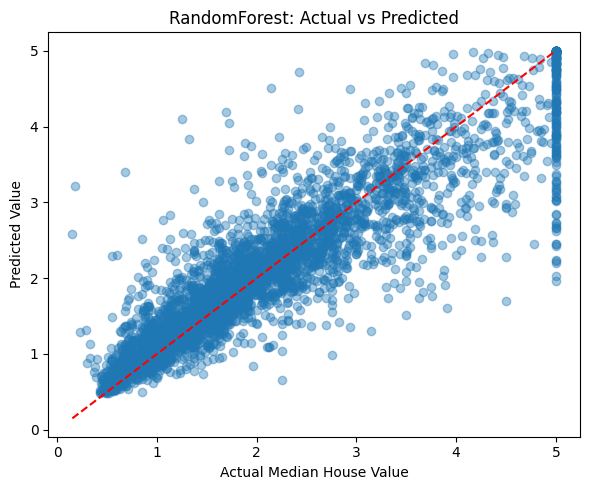

🏃 View run RandomForest at: http://localhost:5000/#/experiments/291998293262015865/runs/59c8828cd62a4088b46652b95a5cb13c
🧪 View experiment at: http://localhost:5000/#/experiments/291998293262015865


In [6]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Mini_MLOps_Project")

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

for model_name, model_obj in models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.sklearn.autolog()

        model_pipeline = Pipeline(steps=[
            ("preprocessing", preprocessor),
            ("model", model_obj)
        ])

        model_pipeline.fit(X_train, y_train)
        predictions = model_pipeline.predict(X_test)
        rmse = mean_squared_error(y_test, predictions)
        mlflow.log_metric("rmse", rmse)

        print(f"✅ {model_name} RMSE: {rmse:.4f}")

        model_path = f"model/{model_name}_pipeline.pkl"
        joblib.dump(model_pipeline, model_path)
        mlflow.log_artifact(model_path)

        plt.figure(figsize=(6, 5))
        plt.scatter(y_test, predictions, alpha=0.4)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
        plt.xlabel("Actual Median House Value")
        plt.ylabel("Predicted Value")
        plt.title(f"{model_name}: Actual vs Predicted")
        plt.tight_layout()
        plot_path = f"model/{model_name}_pred_vs_actual.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.show()

        notes_path = f"model/{model_name}_deployment_notes.txt"
        with open(notes_path, "w") as f:
            f.write(f"{model_name} mock deployment notes:\n")
            f.write("- Model saved as .pkl file\n")
            f.write("- Can be served via FastAPI or Flask\n")
            f.write("- Input features must match California Housing schema\n")
        mlflow.log_artifact(notes_path)